# Data Mining Portfolio # 
## Nathan Cooper Jones - nathancooperjones@gmail.com ## 

In [1]:
import numpy as np 
import pandas as pd 
from scipy import stats 

from sklearn import datasets 
from sklearn import decomposition 
from sklearn.preprocessing import Imputer 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_graphviz 
from sklearn import model_selection 
from sklearn import metrics 

import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
%matplotlib inline 

## Using a Collaborative Recommendation System for Netflix Users ## 

I will begin by creating the utility matrix and centering it by subtracting it by the user means. 

In [2]:
rating_cols = ['user_id', 'movie_id', 'rating', 'timestamp'] 

ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=rating_cols) 

In [3]:
utility = ratings.pivot(index='user_id', columns='movie_id', values='rating') 

utility.head() 

movie_id  1     2     3     4     5     6     7     8     9     10    ...   \
user_id                                                               ...    
1          5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0  ...    
2          4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   2.0  ...    
3          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
4          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
5          4.0   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    

movie_id  1673  1674  1675  1676  1677  1678  1679  1680  1681  1682  
user_id                                                               
1          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
5          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 1682 columns]

In [4]:
user_means = utility.mean(axis=1) 

user_means.head() # sanity check 

user_id
1    3.610294
2    3.709677
3    2.796296
4    4.333333
5    2.874286
dtype: float64

In [5]:
utility_centered = utility - user_means 
utility_centered = utility_centered.where((pd.notnull(utility_centered)),0) 

utility_centered.head() 

1         2         3         4         5         6         7     \
user_id                                                                         
1        1.389706 -0.709677  1.203704 -1.333333  0.125714  1.364929  0.034739   
2        0.389706  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5        0.389706 -0.709677  0.000000  0.000000  0.000000  0.000000  0.000000   

            8         9         10    ...   1673  1674  1675  1676  1677  \
user_id                               ...                                  
1       -2.79661  0.727273 -1.206522  ...    0.0   0.0   0.0   0.0   0.0   
2        0.00000  0.000000 -2.206522  ...    0.0   0.0   0.0   0.0   0.0   
3        0.00000  0.000000  0.000000  ...    0.0   0.0   0.0   0.0   0.0   
4        0.00000  0.000000  0.000000  ...    0.0   0.0   0.0   0.0   0.0   
5        0.00000  0.000000  0.000000  ...    0.0   0.0   0.0   0.0   0.0   

         1678  1679  1680  1681  1682  
user_id                                
1         0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0  
5         0.0   0.0   0.0   0.0   0.0  

[5 rows x 1682 columns]

Next, I will go through and calculate the cosine similarity for each user compared to user 1 and add it to a list which will then be sorted to get the top 10 users who are closest to user 1 in rankings via cosine similarity calculation. 

In [6]:
lst = [] 

feat1 = utility_centered.loc[1:1] 
for x in range(2, utility_centered.shape[0] + 1): 
    feat2 = utility_centered.loc[x:x] 
    lst.append([metrics.pairwise.cosine_similarity(feat1, feat2)[0][0], x]) 

In [7]:
user_means[1] 

3.6102941176470589

In [8]:
lst = sorted(lst, reverse=True) 
lst = lst[0:10] 

lst 

[[0.29148679307800707, 738],
 [0.2784017205961094, 592],
 [0.26815054175880981, 276],
 [0.26476146556668312, 267],
 [0.26400260297782174, 643],
 [0.26236784527028273, 757],
 [0.26233704478060194, 457],
 [0.26084701039863195, 606],
 [0.25562438236025764, 916],
 [0.2529544008014209, 44]]

In [9]:
top_10 = [] 
for x in lst: 
    top_10.append(x[1]) 
    
top_10 = sorted(top_10) 
top_10 

[44, 267, 276, 457, 592, 606, 643, 738, 757, 916]

Now with the top 10 users most similar to user 1 via cosine similarity calculation being users 44, 267, 276, 457, 592, 606, 643, 738, 757, and 916, we can now see what each of these ten users rated movie 508 [<i>The People vs. Larry Flynt</i> (1996)] and use the mean of all of these values added to the average rating that user 1 gives as our predicted value for user 1 (the exact process which Leskovec describes in <em>Mining of Massive Datasets</em> accessible at http://infolab.stanford.edu/~ullman/mmds/book.pdf). Note that some of these ten users did not rate movie 508 and thus are not counted in the calculation of the mean (example, user 44 did not rate the movie at all but user 276 did, so 276 is counted towards the mean. In total, four users out of the ten actually rated movie 508). 

In [10]:
# now let's do the second half of the question 
sum = 0 
count = 0 

for x in top_10: 
    val = utility_centered.loc[x, 508] 
    if val: 
        sum += val 
        count += 1 
        
mean = sum / count 
mean 

0.6724137931034484

In [11]:
expected_rating = user_means[1] + mean 
expected_rating 

4.2827079107505073

With all that work finally done, we can conclude that user 1 would likely rate <i>The People vs. Larry Flynt</i> a <b>4.28 out of 5</b>. One thing is for sure: an algorithm using this approach would most definitely recommend the movie to user 1 to watch, since multiple users similar to this user watched and liked this selection. 

## Using Decision Trees to Draw Conclusions from Two Distributions ## 

We will begin by randomly generating two different sets of Normal distributions, each with N = 1000. However, x1 will be centered with mean 5 while x2 will be centered with mean -5. 

In [12]:
N = 1000 
x1 = np.random.normal(5, 2, N) 
c1 = np.repeat('0', N) 
x2 = np.random.normal(-5, 2, N) 
c2 = np.repeat('1', N) 

(array([  1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,   1.,
          0.,   0.,   3.,   0.,   2.,   3.,   3.,   8.,   7.,   3.,  11.,
          8.,  11.,  10.,  10.,   7.,  13.,   4.,   6.,   9.,   7.,  17.,
         16.,  20.,  14.,  21.,  17.,  29.,  23.,  24.,  27.,  14.,  27.,
         22.,  30.,  18.,  16.,  20.,  16.,  23.,  33.,  25.,  25.,  22.,
         19.,  25.,  20.,  24.,  20.,  20.,  22.,  18.,  12.,  19.,  12.,
         11.,  20.,  13.,  10.,   9.,  10.,   7.,  13.,   5.,   5.,  10.,
          5.,   2.,   4.,   5.,   4.,   1.,   3.,   2.,   4.,   2.,   2.,
          4.,   0.,   2.,   0.,   1.,   1.,   3.,   0.,   0.,   0.,   1.,
          1.]), array([ -1.16186638,  -1.03779776,  -0.91372914,  -0.78966051,
         -0.66559189,  -0.54152327,  -0.41745465,  -0.29338603,
         -0.16931741,  -0.04524879,   0.07881983,   0.20288845,
          0.32695707,   0.45102569,   0.57509431,   0.69916293,
          0.82323156,   0.94730018,   1.0713688 ,   1.19543742,

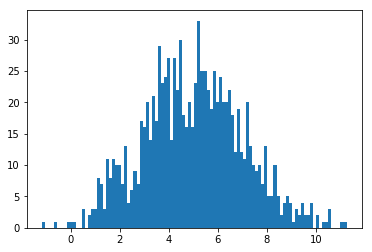

In [13]:
plt.hist(x1, bins=100) 

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   1.,
          3.,   3.,   2.,   3.,   5.,   7.,   4.,   5.,   7.,  10.,   7.,
         10.,   3.,  10.,  10.,  15.,  16.,  18.,  18.,  17.,  16.,  20.,
         23.,  22.,  38.,  21.,  25.,  28.,  28.,  38.,  27.,  37.,  15.,
         30.,  30.,  34.,  38.,  29.,  31.,  28.,  22.,  27.,  25.,  14.,
         13.,  17.,  24.,  10.,  12.,  11.,   8.,  12.,  13.,   6.,   7.,
          7.,   6.,   8.,   2.,   4.,   1.,   1.,   1.,   3.,   2.,   0.,
          0.,   1.,   3.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   1.,
          1.]), array([ -1.32144464e+01,  -1.30625927e+01,  -1.29107389e+01,
         -1.27588852e+01,  -1.26070314e+01,  -1.24551777e+01,
         -1.23033239e+01,  -1.21514702e+01,  -1.19996164e+01,
         -1.18477627e+01,  -1.16959089e+01,  -1.15440552e+01,
         -1.13922014e+01,  -1.12403477e+01,  -1.10884939e+01,
         

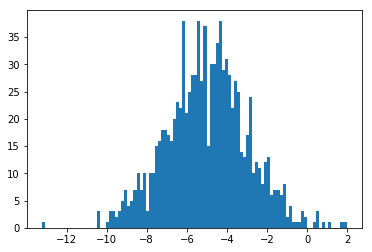

In [14]:
plt.hist(x2, bins=100) 

In [15]:
print("x1 mean: {}, x2 mean: {}".format(x1.mean(), x2.mean())) 

x1 mean: 5.003800218971892, x2 mean: -4.992537301817326


In [16]:
df1 = pd.DataFrame(dict(zip(['value','class'],[x1,c1]))) 
df2 = pd.DataFrame(dict(zip(['value','class'],[x2,c2]))) 
df = df1.append(df2) 
df.describe() 

value
count  2000.000000
mean      0.005631
std       5.391157
min     -13.214446
25%      -5.019632
50%       0.490347
75%       5.038763
max      11.244996

We will now select a sample of 80% from each of the two Normal distributions and use it to train our model to differentiate between the two (we will expect positive numbers to be grouped with x1 while negative numbers should be grouped with x2). We will then use the remaining 20% of the data to test the model; the results of this test are below. 

In [17]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df[['value']], df['class'], test_size=0.2) 

In [18]:
clf = DecisionTreeClassifier(max_depth=2) 
clf = clf.fit(X_train, y_train) 
expected = y_test 
predicted = clf.predict(X_test) 

print(metrics.classification_report(expected, predicted)) 

             precision    recall  f1-score   support

          0       0.99      1.00      0.99       209
          1       1.00      0.98      0.99       191

avg / total       0.99      0.99      0.99       400



In [19]:
from sklearn.tree import _tree 
threshold = clf.tree_.threshold 
threshold[0] 

-0.10302744805812836

In [20]:
from sklearn import tree 
tree.export_graphviz(clf, out_file='tree.dot') 

import pydot 

(graph,) = pydot.graph_from_dot_file('tree.dot') 
graph.write_png('tree.png') 

True

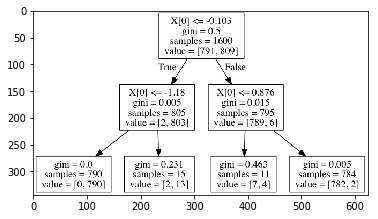

In [21]:
img = mpimg.imread('tree.png') 
plt.imshow(img) 

plt.show() 

Naturally by combining two normal distributions on exact opposite sides of the y-axis, we would expect our threshold value for choosing which distribution a given value falls into would be a threshold of 0 on average, since a negative number should fall into the negative distribution (-5, 2) and a positive value should fall into the positive distribution (5,2), naturally. However, during this randomized run, our threshold value for the split actually tests if the number is <= -0.103 or > -0.103, a threshold value which is very close to 0, but not quite 0. In other runs, I've even had the threshold number be almost as big as 0.5! Hence, because we are taking a randomized distribution and then randomly sampling from that to form a decision tree, the threshold value might be some positive or some negative value centered around 0 that decides where to split to put the value in the correct positive or negative normal distribution. 

## Working with PCA on the Iris Dataset ## 

In [22]:
df = pd.read_csv('iris.data', sep=',') 
df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class'] 
pca = decomposition.PCA(n_components=2) 
pca.fit(df.iloc[:,0:4]) 
X = pca.transform(df.iloc[:,0:4]) 

In [23]:
dataset = datasets.load_iris() 
dataset.keys() 
df = pd.DataFrame(dataset.data, columns=dataset.feature_names) 
df['class'] = dataset.target_names[dataset.target] 
df.head() 

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

    class  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa

In [24]:
pca = decomposition.PCA(n_components=2) 
pca.fit(df.iloc[:,0:4]) 
X = pca.transform(df.iloc[:,0:4]) 

X[:,0].var() 

4.1966751631979804

In [25]:
dfX = pd.DataFrame(data=X[:,0]) 

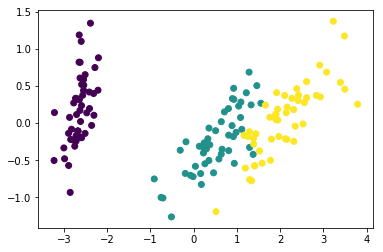

In [26]:
plt.scatter(X[:,0], X[:,1], c=dataset.target) 
# original PCA 

----- 

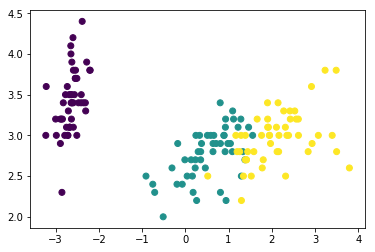

In [27]:
plt.scatter(X[:,0], df['sepal width (cm)'], c=dataset.target) 

In [28]:
dfX[0].corr(df['sepal width (cm)']) 

-0.38999337904750564

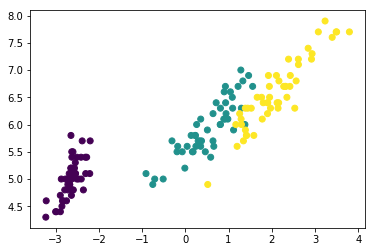

In [29]:
plt.scatter(X[:,0], df['sepal length (cm)'], c=dataset.target) 

In [30]:
dfX[0].corr(df['sepal length (cm)']) 

0.89754488494076157

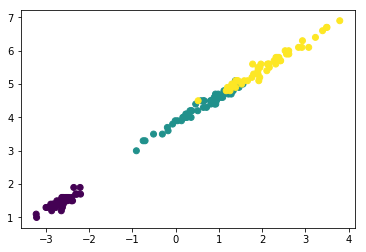

In [31]:
plt.scatter(X[:,0], df['petal length (cm)'], c=dataset.target) 

In [32]:
dfX[0].corr(df['petal length (cm)']) 

0.99785405063545973

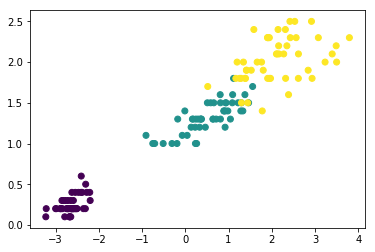

In [33]:
plt.scatter(X[:,0], df['petal width (cm)'], c=dataset.target) 

In [34]:
dfX[0].corr(df['petal width (cm)']) 

0.96648418315379248

From the above four graphs, it is clear that the graph comparing the first component of our PCA (PC1) and petal length produce the tightest, most correlated scatter plot. When looking at the cosine distance which measures the angle between the two different axes in this case, we see that the distance is minimized almost entirely with this graph compared to one such as PC1 vs sepal width. A simple inspection from the above problem 3 shows that PC1 contains the largest amount of variation of all the components as petal length does the same out of the other three features. When we further solidify our inspection by actually calculating the correlation, we find that PC1 vs petal length gives a correlation of about 0.998, which is nearly 1, the most linear reading a correlation can give. With the assurance that PC1 vs sepal width gives the correlation closest to 0, we can assure ourselves that we have selected the correct pair of features. 

----- 

In [35]:
pca = decomposition.PCA(n_components=4) 
pca.fit(df.iloc[:,0:4]) 
X = pca.transform(df.iloc[:,0:4]) 
pca.explained_variance_ 

array([ 4.22484077,  0.24224357,  0.07852391,  0.02368303])

In [36]:
pca.explained_variance_.sum() 

4.569291275167787

In [37]:
df.var().sum() 

4.5692912751677826

In [38]:
pca.explained_variance_ratio_.cumsum() 

array([ 0.92461621,  0.97763178,  0.99481691,  1.        ])

As alluded to in Problem 3, we see fully that when we compute the PCA with the same number of components as the original features, we find that we still capture the full variance of the original features. The advantage of PCA over using the original features, however, is that we can still capture a large majority of the variability by using less features. We see this in action when we look at the sum of the explained variance ratios. By using one component, we capture about 92.4% of the total variance, by using two, we capture about 97.8%, three we capture nearly 99.5%, and of course by using all four, we capture the full, total variability. Unlike the original attributes where the best one feature will get us is around 66%, one feature after PCA will get drastically more variability. To get 95% of our total variability of our original features would require all of three of our features, but after PCA, it only takes two features to get us far above the 95% mark. Hence, our PCA worked in decreasing our dimensions while not decreasing the majority of our variability to work with. 

## Clustering Data with an Optimal Number of Clusters ## 

In [39]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.cluster import KMeans 
from sklearn import preprocessing 
from sklearn import metrics 

from sklearn.datasets import load_boston 

%matplotlib inline 

In [40]:
dataset = load_boston() 
print(dataset.DESCR) 

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

We will begin by scaling the dataset and then find the best number of clusters that reduces the overall silhouette score of the model. 

In [41]:
df_scaled = pd.DataFrame(data=preprocessing.scale(dataset.data), columns=dataset.feature_names) 
df_scaled.head() 

CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
0 -0.417713  0.284830 -1.287909 -0.272599 -0.144217  0.413672 -0.120013   
1 -0.415269 -0.487722 -0.593381 -0.272599 -0.740262  0.194274  0.367166   
2 -0.415272 -0.487722 -0.593381 -0.272599 -0.740262  1.282714 -0.265812   
3 -0.414680 -0.487722 -1.306878 -0.272599 -0.835284  1.016303 -0.809889   
4 -0.410409 -0.487722 -1.306878 -0.272599 -0.835284  1.228577 -0.511180   

        DIS       RAD       TAX   PTRATIO         B     LSTAT  
0  0.140214 -0.982843 -0.666608 -1.459000  0.441052 -1.075562  
1  0.557160 -0.867883 -0.987329 -0.303094  0.441052 -0.492439  
2  0.557160 -0.867883 -0.987329 -0.303094  0.396427 -1.208727  
3  1.077737 -0.752922 -1.106115  0.113032  0.416163 -1.361517  
4  1.077737 -0.752922 -1.106115  0.113032  0.441052 -1.026501

In [42]:
for n in range(2, 7): 
    clust_model = KMeans(n_clusters=n, init='k-means++') 
    clust_labels = clust_model.fit_predict(df_scaled) 
    silhouette_avg = metrics.silhouette_score(df_scaled, clust_labels) 
    print("Silhouette score for k = {} = {}".format(n, silhouette_avg)) 

Silhouette score for k = 2 = 0.35997734237402634
Silhouette score for k = 3 = 0.2573437376110001
Silhouette score for k = 4 = 0.2896770051612737
Silhouette score for k = 5 = 0.287487114888814
Silhouette score for k = 6 = 0.26139281284115573


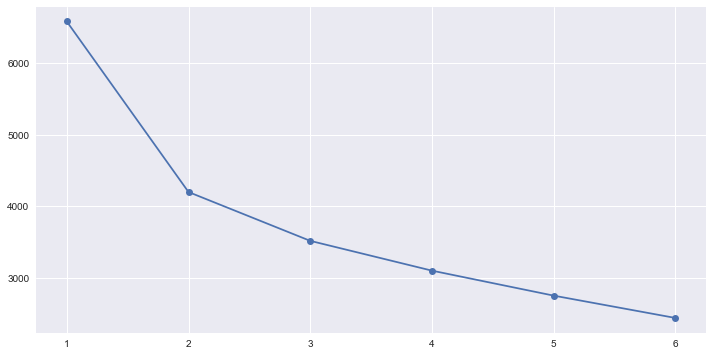

In [43]:
# just to double check, here's an elbow analysis mostly 
# taken from http://www.awesomestats.in/python-cluster-validation/ 

X = df_scaled[list(df_scaled.columns)] 

from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) 

cluster_range = range(1, 7) 
cluster_errors = [] 

for num_clusters in cluster_range: 
    clusters = KMeans(num_clusters) 
    clusters.fit(X_scaled) 
    cluster_errors.append(clusters.inertia_) 
    
clusters_df = pd.DataFrame({ "num_clusters":cluster_range, "cluster_errors": cluster_errors}) 

plt.figure(figsize=(12,6)) 
plt.plot(clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o") 

In [44]:
# clearly from the silhouette scores above, the optimal value of k is 2 for the scaled data 
clust_model = KMeans(n_clusters = 2, init='k-means++') 
clust_labels = clust_model.fit_predict(df_scaled) 
print(clust_labels) 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [45]:
silhouette_avg = metrics.silhouette_score(df_scaled, clust_labels) 
print(silhouette_avg) 

0.359977342374


With optimal number of clusters being k=2, we will continue on by comparing the mean values for all features in each cluster as well as the centroid coordinates. 

In [46]:
df_scaled['CLUST'] = clust_labels 
C0 = df_scaled.loc[df_scaled['CLUST'] == 0] 
C0.mean() 

CRIM      -0.388039
ZN         0.262392
INDUS     -0.620368
CHAS       0.002912
NOX       -0.584675
RM         0.243315
AGE       -0.435108
DIS        0.457222
RAD       -0.583801
TAX       -0.631460
PTRATIO   -0.285808
B          0.326451
LSTAT     -0.446421
CLUST      0.000000
dtype: float64

In [47]:
df_scaled['CLUST'] = clust_labels 
C1 = df_scaled.loc[df_scaled['CLUST'] == 1] 
C1.mean() 

CRIM       0.721270
ZN        -0.487722
INDUS      1.153113
CHAS      -0.005412
NOX        1.086769
RM        -0.452263
AGE        0.808760
DIS       -0.849865
RAD        1.085145
TAX        1.173731
PTRATIO    0.531248
B         -0.606793
LSTAT      0.829787
CLUST      1.000000
dtype: float64

In [48]:
print("Cluster coordinates: \n{}".format(clust_model.cluster_centers_)) 

Cluster coordinates: 
[[-0.38803894  0.26239167 -0.62036759  0.00291182 -0.58467512  0.24331476
  -0.43510819  0.45722226 -0.58380115 -0.63145993 -0.28580826  0.32645106
  -0.44642061]
 [ 0.72127012 -0.48772236  1.15311264 -0.00541237  1.086769   -0.45226302
   0.80876041 -0.8498651   1.0851445   1.1737306   0.53124811 -0.60679321
   0.82978746]]


//anaconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


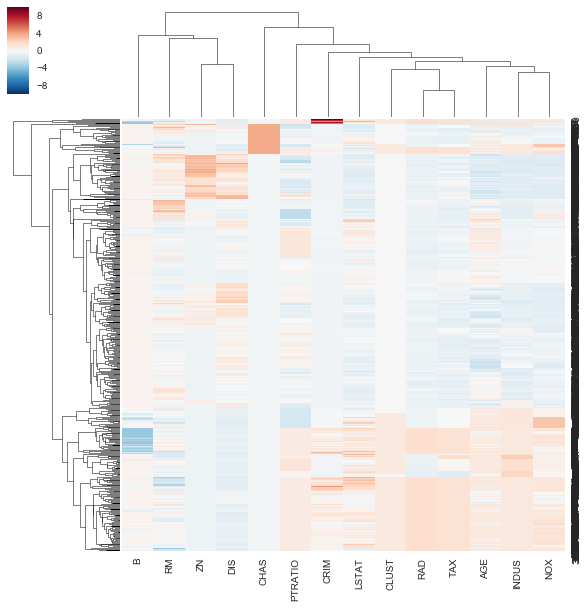

In [49]:
sns.clustermap(df_scaled, method='average', metric='euclidean', z_score=None, standard_scale=None) 